# 使用神经网络进行窃漏电识别

------
大多数终端可以报警窃漏电用户，但存在较多的误报和漏报的情况，窃漏电识别主要是从大数据中探索该类用户的行为规律，从庞大的数据中提炼其特征指标，并结合历史数据建立模型，从而实现自动识别。
特征提取方面因为没有原始数据，本文中的数据来自《Python数据分析与挖掘实战》，其特征已经提出为如下三个：
> * 电量趋势下降指标：用电量趋势，正常用户用电量较平稳，窃漏电用户呈现下降趋势，然后趋于平稳
> * 线损指标：线损增长率，用户发送窃漏电时，当天线损率会上升，为减少误差，考虑前后几天的线损率平均值
> * 告警类指标：与窃漏电相关的终端告警数，主要有电压缺相、电压断相、电流反极性等

首先看看数据的大致情况：

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文字体设置-黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题
sns.set(font='SimHei')  # 解决Seaborn中文显示问题

%matplotlib inline
%config InlineBackend.figure_format = "retina"

file = './dataset/窃电数据.csv'
df = pd.read_csv(file)
df.head()

,电量趋势下降指标,线损指标,告警类指标,是否窃漏电
0,4,1,1,1
1,4,0,4,1
2,2,1,1,1
3,9,0,0,0
4,3,1,0,0


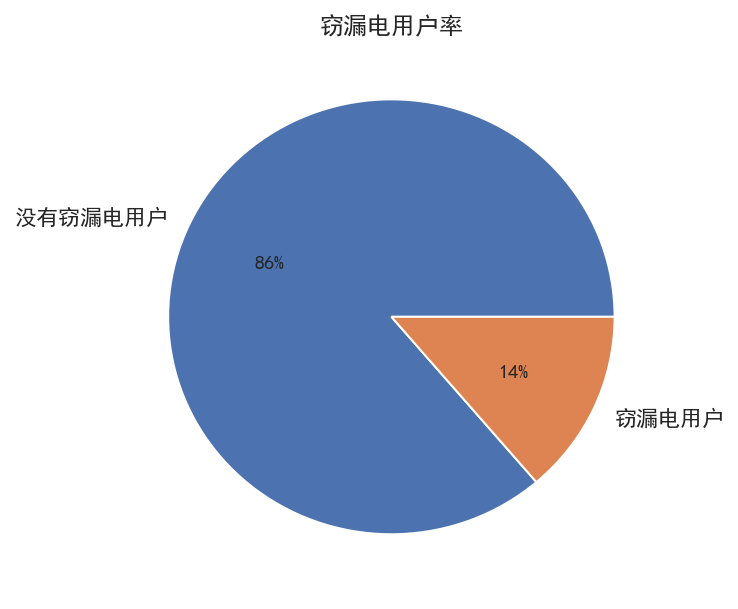

In [10]:
stealing_users = df['是否窃漏电'].sum()
no_stealing_users = len(df) - stealing_users

plt.figure(figsize = (5,5))
plt.pie([no_stealing_users, stealing_users],labels=['没有窃漏电用户','窃漏电用户'],autopct='%1.0f%%')
plt.title('窃漏电用户率') 
plt.show()

从上可以看出窃电用户占比14%，接下来探索一下各特征和窃电的关系。

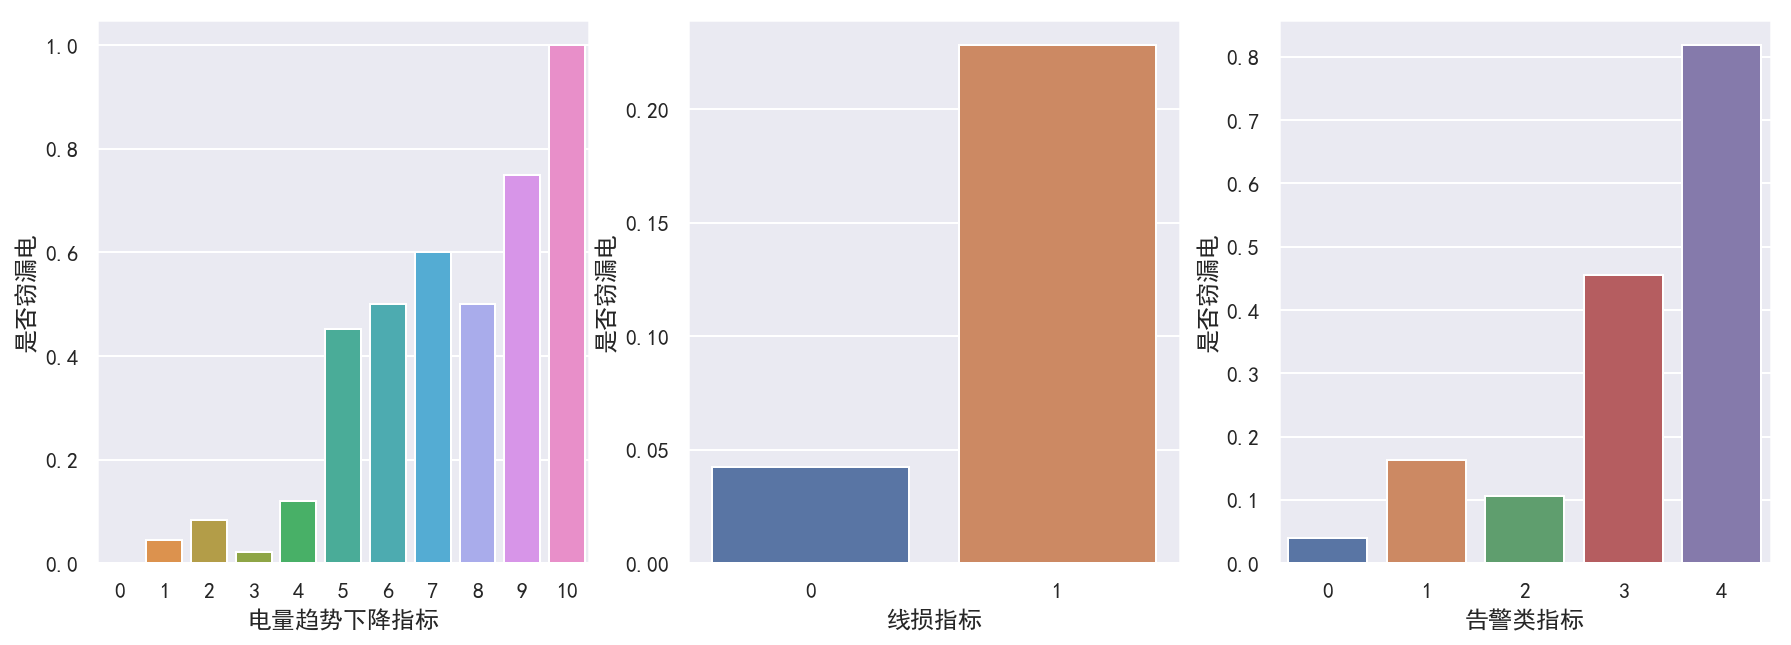

In [11]:
plt.figure(figsize= (15, 5))
plt.subplot(131)
sns.barplot(data=df,x="电量趋势下降指标",y="是否窃漏电",ci=None) 
plt.subplot(132)
sns.barplot(data=df,x="线损指标",y="是否窃漏电",ci=None) 
plt.subplot(133)
sns.barplot(data=df,x="告警类指标",y="是否窃漏电",ci=None) 
plt.show()

从上图可以看出，特征值越大，窃漏电的可能性总体呈现上升趋势，接下来查看不同线损下的特征曲线：

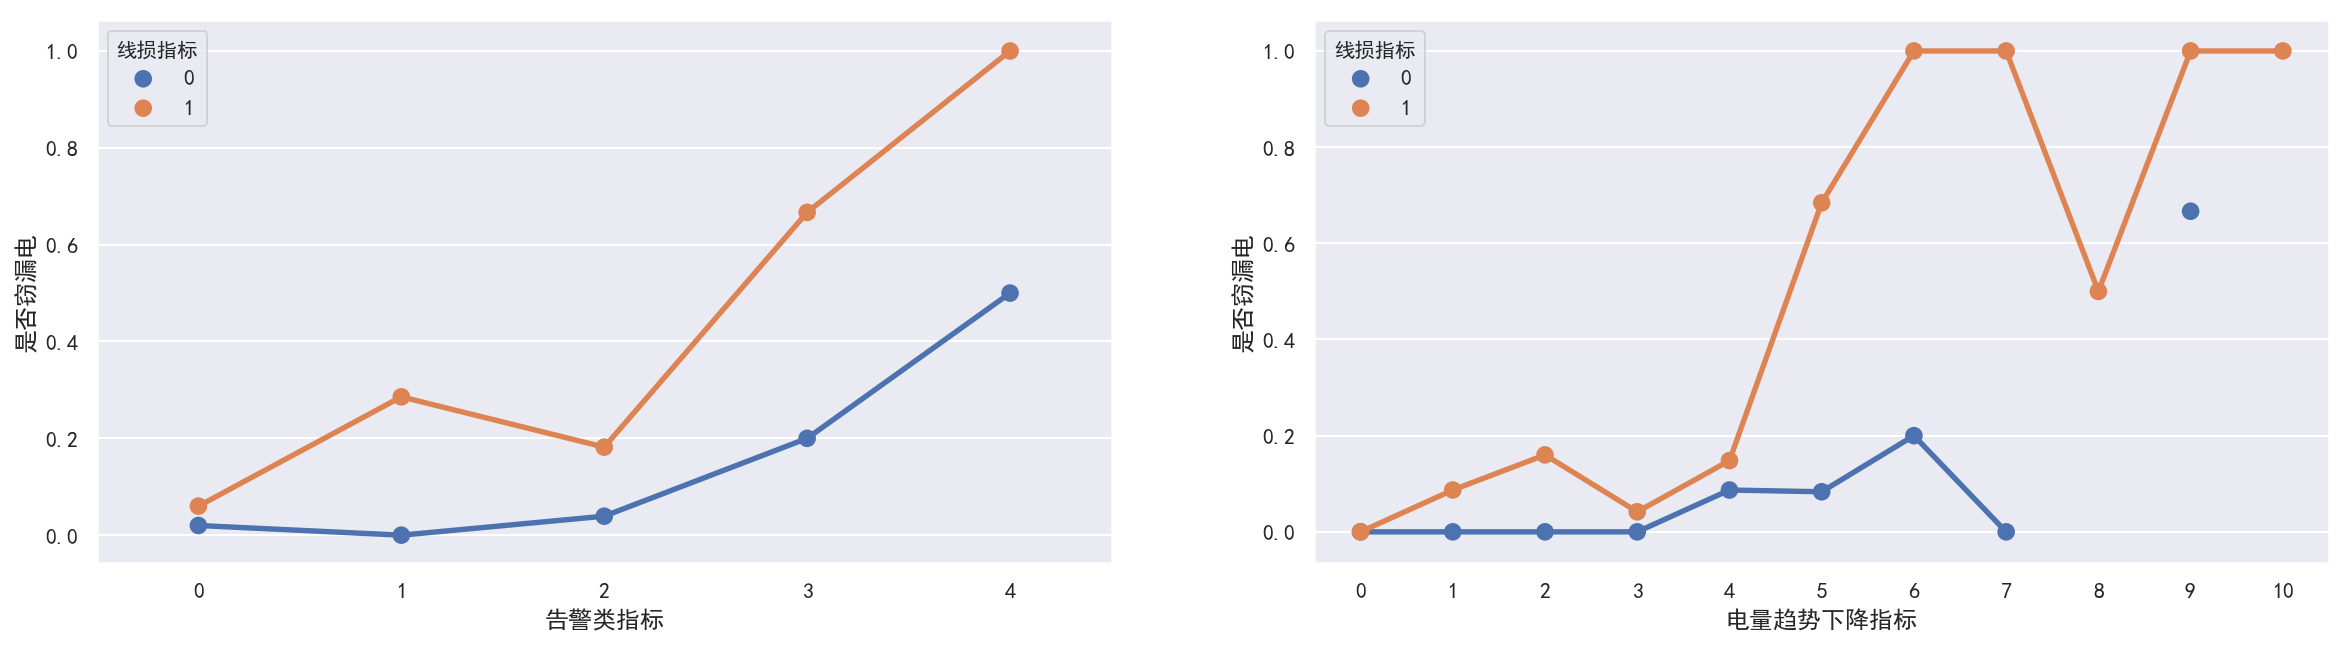

In [12]:
plt.figure(figsize= (20, 5))
plt.subplot(121)
sns.pointplot(data=df,x="告警类指标",y="是否窃漏电",hue="线损指标",ci=None)
plt.subplot(122)
sns.pointplot(data=df,x="电量趋势下降指标",y="是否窃漏电",hue="线损指标",ci=None)
plt.show()

**结论：**
1. 在各种情况下，有线损的情况窃漏电概率比较大，线损是首要考虑指标。
2. 告警类指标大于等于3时，窃漏电概率越大。
3. 电量趋势下降指标大于4时，窃漏电概率猛增

下面采用一个简单的神经网络来建模处理。

In [13]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

tf.reset_default_graph() 

# 三层神经网络，输入节点数为3，隐藏层节点数为10，输出种类为2
INPUT_NODE = 3
NN_NODE = 10
OUTPUT_NODE = 2
BATCH_SIZE = 32
# 正则化系数
REGULARIZATION_RATE = 0.0001
# 训练轮数
TRAINING_STEPS = 2000
# 学习率
learning_rate = 0.0001

In [14]:
# 加载csv数据，返回训练数据集测试数据
def load_data(input_file):
    data = pd.read_csv(input_file)
    X = data[['电量趋势下降指标','线损指标','告警类指标']]
    Y = data[['是否窃漏电']]
    ohe = OneHotEncoder(categorical_features=[0])
    y = ohe.fit_transform(Y).toarray()
    # 理论上正负样本要按比例分到训练集和测试集，这里忽略了
    train_data, test_data, train_label, test_label = train_test_split(X, y, test_size=0.2)
    return train_data, train_label, test_data, test_label

In [15]:
# 前向传播计算过程
def inference(input_tensor, regularizer, reuse=False):
    with tf.variable_scope('layer1', reuse=reuse):
        weights = tf.get_variable('weights', [INPUT_NODE, NN_NODE], initializer=tf.truncated_normal_initializer(stddev=0.1))
        if regularizer is not None:
            tf.add_to_collection('losses', regularizer(weights))
        biases = tf.get_variable('biases', [NN_NODE], initializer=tf.constant_initializer(0.0))
        layer1 = tf.nn.relu(tf.matmul(input_tensor, weights) + biases)
    with tf.variable_scope('layer2', reuse=reuse):
        weights = tf.get_variable('weights', [NN_NODE, OUTPUT_NODE], initializer=tf.truncated_normal_initializer(stddev=0.1))
        if regularizer is not None:
            tf.add_to_collection('losses', regularizer(weights))
        biases = tf.get_variable('biases', [OUTPUT_NODE], initializer=tf.constant_initializer(0.0))
        result = tf.matmul(layer1, weights) + biases
    return result

In [16]:
# 训练过程
def train():
    # 由于数据集实在太小，这里没有划分出验证集
    train_data, train_label, test_data, test_label = load_data(file)
    
    # 定义数据及批量大小占位符
    batch_size = tf.placeholder(tf.int64)
    x = tf.placeholder(tf.float32, [None, INPUT_NODE], name='x-input')
    y = tf.placeholder(tf.float32, [None, OUTPUT_NODE], name='y-input')
    
    # 定义测试和验证的dataset
    dataset = tf.data.Dataset.from_tensor_slices((x, y)).batch(batch_size).repeat()
    iterator = dataset.make_initializable_iterator()
    features, labels = iterator.get_next()
    
    # 定义L2正则化
    regularizer = tf.contrib.layers.l2_regularizer(REGULARIZATION_RATE)
    # 计算训练场景下前向传播结果
    prediction = inference(features, regularizer)
    
    # 定义保存训练轮数的变量，设置为不可训练变量，避免后面滑动平均时修改（即不在tf.trainable_variables()中）
    global_step = tf.Variable(0, trainable=False)
    
    # 定义损失函数
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=prediction, labels=tf.argmax(labels,1))
    loss = tf.reduce_mean(cross_entropy)

    # 定义优化函数
    train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    
    # 定义精度计算
    correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(labels, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # 计算测试场景下前向传播结果
    test_prediction = inference(features, None, reuse=True)
    test_corrent_prediction = tf.equal(tf.argmax(test_prediction, 1), tf.argmax(labels, 1))
    test_accuracy = tf.reduce_mean(tf.cast(test_corrent_prediction, tf.float32))
    
    n_batchs = train_data.shape[0]
    # 模型保存
    saver = tf.train.Saver()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sess.run(iterator.initializer, feed_dict={x: train_data, y: train_label, batch_size: BATCH_SIZE})
        print('开始训练')
        for step in range(1, TRAINING_STEPS + 1):
            total_loss = 0
            for _ in range(n_batchs):
                _, loss_value, _ = sess.run([train_step, loss, accuracy])
                total_loss += loss_value
            if step % 100 == 0:
                print('Step %d, loss = %.2f,' % (step, loss_value))
        sess.run(iterator.initializer, feed_dict={x: test_data, y: test_label, batch_size: test_data.shape[0]})
        test_accuracy = sess.run(test_accuracy)
        saver.save(sess, './model/snn/model.ckpt')
        print('**  测试精度 = %.3f%%  **' % (test_accuracy * 100.0))

In [17]:
train()

开始训练
Step 100, loss = 0.43,
Step 200, loss = 0.39,
Step 300, loss = 0.36,
Step 400, loss = 0.33,
Step 500, loss = 0.31,
Step 600, loss = 0.29,
Step 700, loss = 0.27,
Step 800, loss = 0.25,
Step 900, loss = 0.23,
Step 1000, loss = 0.21,
Step 1100, loss = 0.20,
Step 1200, loss = 0.19,
Step 1300, loss = 0.17,
Step 1400, loss = 0.17,
Step 1500, loss = 0.16,
Step 1600, loss = 0.15,
Step 1700, loss = 0.15,
Step 1800, loss = 0.14,
Step 1900, loss = 0.14,
Step 2000, loss = 0.13,
**  测试精度 = 89.831%  **


In [71]:
def evaluate_all_image():
    datas = [[[2,1,4]],[[1,0,2]]]
    x = tf.placeholder(tf.float32, [None, INPUT_NODE])
    logits = inference(x, None)
    logit = tf.nn.softmax(logits)
    saver = tf.train.Saver()
    with tf.Session() as sess:
        ckpt = tf.train.get_checkpoint_state('./model/snn')
        if ckpt and ckpt.model_checkpoint_path:
            global_step = ckpt.model_checkpoint_path.split('/')[-1].split('-')[-1]
            saver.restore(sess, ckpt.model_checkpoint_path)
            print('模型加载成功, global_step is %s' % global_step)
        else:
            print('模型加载失败')
#         prediction = sess.run([logit], feed_dict={x: [[2,1,4]]})
        
        for data in datas:
            print('要预测的值：', data)
            prediction = sess.run([logit], feed_dict={x: data})
            max_index = np.argmax(prediction)
            print(prediction)
            print(max_index)
            if max_index == 0:
                print('正常的概率为 %.6f' % prediction[0][0][0])
            else:
                print('窃漏电的概率为 %.6f' % prediction[0][0][1])
            print('-------------------------------')

            
tf.reset_default_graph() 
evaluate_all_image()

INFO:tensorflow:Restoring parameters from ./model/snn/model.ckpt
模型加载成功, global_step is model.ckpt
要预测的值： [[2, 1, 4]]
[array([[0.3343419, 0.6656581]], dtype=float32)]
1
窃漏电的概率为 0.665658
-------------------------------
要预测的值： [[1, 0, 2]]
[array([[0.9893638 , 0.01063625]], dtype=float32)]
0
正常的概率为 0.989364
-------------------------------
